In [2]:
"""
Train MetaDSP Model with split windows.
"""

import pickle, torch, numpy as np, time, argparse, os , yaml, jax
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from functools import partial
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.tensorboard.writer import SummaryWriter
from src.TorchDSP.core import TorchInput, TorchSignal, TorchTime
from src.TorchDSP.dsp import DSP, LDBP, downsamp, ADF, TestDBP
from src.TorchDSP.train_dbp import Test, Train, DDLMS_jax
from src.TorchDSP.dataloader import  MyDataset
from src.TorchDSP.loss import BER_well, MSE, SNR, Qsq
from src.TorchSimulation.receiver import  BER
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime

test_data = MyDataset('dataset_A800/test.h5',  Nch=[21], Rs=[80], Pch=[2], Nmodes=2,
                        window_size=100000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP32')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=True)

for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

torch.Size([1, 200000, 2]) torch.Size([1, 100000, 2]) torch.Size([1, 4])


## Training

In [7]:
with open('configs/metadsp/metadbp_Nmodes2.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

net = LDBP(cfg['model_info']['DBP_info']).to(cfg['device'])
conv = downsamp(taps=64, Nmodes=2, sps=2, init='zeros').to(cfg['device'])
optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': 3e-4}, {'params': conv.parameters(), 'lr': 3e-4}])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Concat data loader

Nwindow = 10000

train_datas = []
for nch in [21]:
    for rs in [40]:
        for pch in [2]:
            train_datas.append(MyDataset(cfg['train_path'], Nch=[nch], Rs=[rs], Pch=[pch], Nmodes=2,
                            window_size=cfg['tbpl'] + net.overlaps + conv.overlaps, strides=cfg['tbpl'], Nwindow=Nwindow, truncate=0,
                            Tx_window=True, pre_transform='Rx'))
dataset = ConcatDataset(train_datas)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
print(len(train_loader))

test_info = {'Pch': 2, 'Rs': 40, 'Nch': 21}

log_path = f'_outputs/log_tensorboard/NewDBP/test_{rs}'
model_path = f'_models/NewDBP/test_{rs}'
Train(net, conv, train_loader, optimizer, scheduler, log_path, model_path, epoch_init=0, epochs=30, test_info=test_info, save_log=True, save_model=True, save_interval=1, device=cfg['device'])

# kernel = net.task_mlp.parameter.reshape(2,2, cfg['model_info']['DBP_info']['ntaps']).data.cpu()
# torch.save(kernel, f'_outputs/kernel/{Rs}G_{Nch}ch.pt')

24
Epoch: 0, Loss: 0.98814, time: 3.61430
Test BER: 0.47839, Qsq: -25.31985, MSE: 2.19765
Model saved
Epoch: 1, Loss: 0.90752, time: 3.53451
Test BER: 0.04439, Qsq: 4.61843, MSE: 0.08375
Model saved
Epoch: 2, Loss: 0.82231, time: 3.60045
Test BER: 0.02728, Qsq: 5.67677, MSE: 0.06250
Model saved
Epoch: 3, Loss: 0.75160, time: 3.64479
Test BER: 0.02341, Qsq: 5.96780, MSE: 0.05848
Model saved
Epoch: 4, Loss: 0.69174, time: 3.54451
Test BER: 0.03671, Qsq: 5.05793, MSE: 0.07331
Model saved
Epoch: 5, Loss: 0.63579, time: 3.56016
Test BER: 0.02310, Qsq: 5.99259, MSE: 0.05881
Model saved


KeyboardInterrupt: 

#  Test

In [15]:
Q = []

In [58]:
for Rs in [40, 80, 160, 'all']:
    model_path = f'_models/NewDBP/test_{Rs}'
    dic = torch.load(model_path + '/30.pth')
    net = LDBP(dic['dbp_info'])
    net.load_state_dict(dic['dbp_param'])
    net = net.to('cuda:0')

    Q.append([Test(net, 'cuda:0', 32,  Pch=pch, Nch=nch, Rs=rs)['Qsq'] for pch, nch, rs in [[-1, 21, 40], [2, 21, 80], [4, 21, 160]]])

Text(0.5, 1.0, 'Q factor')

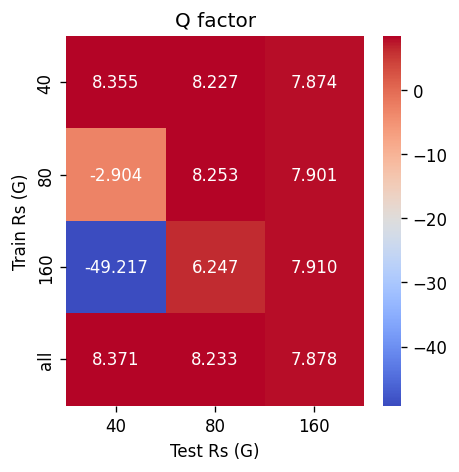

In [66]:

import seaborn as sns
import matplotlib.pyplot as plt

# show Q0 in a hitmap with .3f scheme, set range of color bar to -0.1 to 0.1
plt.figure(dpi=120, figsize=(4,4))
sns.heatmap(np.array(Q), annot=True, fmt='.3f', cmap='coolwarm', xticklabels=[40, 80, 160], yticklabels=[40, 80, 160, 'all'])

plt.xlabel('Test Rs (G)')
plt.ylabel('Train Rs (G)')
plt.title('Q factor')


In [10]:
kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

Rs = 160
model_path = f'_models/NewDBP/test_{Rs}'
dic = torch.load(model_path + '/20.pth')
net = LDBP(dic['dbp_info'])
net.load_state_dict(dic['dbp_param'])
net = net.to('cuda:0')

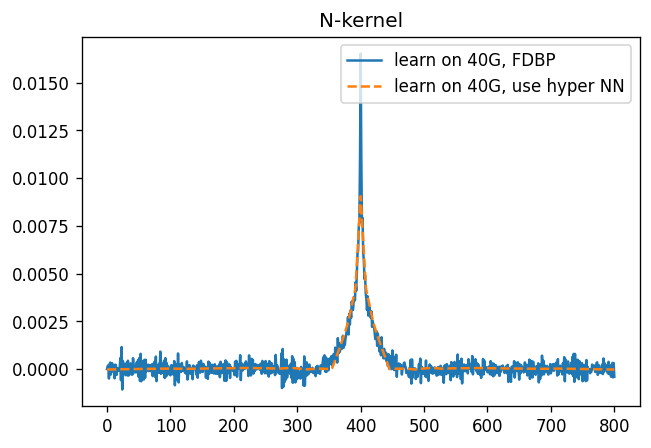

In [14]:
import matplotlib.pyplot as plt
k = net.get_N_kernel(torch.tensor([[0,0,80e9,0]]).to('cuda:0'))[0].cpu().data

plt.figure(dpi=120, figsize=(6,4))
plt.plot(kernels['40G_21ch'][0,1], label='learn on 40G, FDBP')
plt.plot(k[0,1], '--', label='learn on 40G, use hyper NN')
plt.title('N-kernel')
plt.legend()

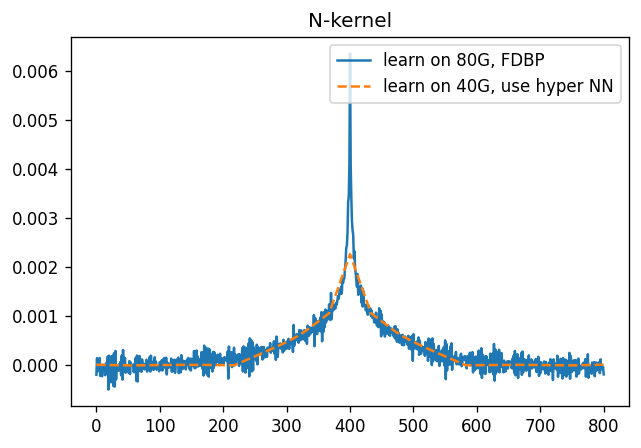

In [15]:

k = net.get_N_kernel(torch.tensor([[0,0,160e9,0]]).to('cuda:0'))[0].cpu().data

plt.figure(dpi=120, figsize=(6,4))
plt.plot(kernels['80G_21ch'][0,1], label='learn on 80G, FDBP')
plt.plot(k[0,1], '--', label='learn on 40G, use hyper NN')
plt.title('N-kernel')
plt.legend()

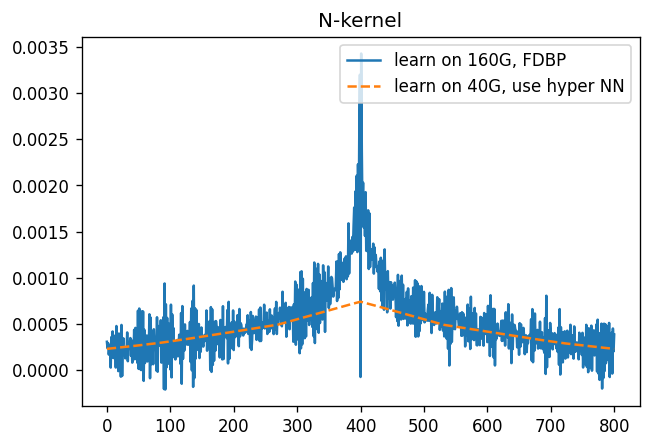

In [8]:

k = net.get_N_kernel(torch.tensor([[0,0,320e9,0]]).to('cuda:0'))[0].cpu().data

plt.figure(dpi=120, figsize=(6,4))
plt.plot(kernels['160G_21ch'][0,0], label='learn on 160G, FDBP')
plt.plot(k[0,0], '--', label='learn on 40G, use hyper NN')
plt.title('N-kernel')
plt.legend()

## show FDBP filter

In [12]:
import torch
import matplotlib.pyplot as plt
kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

(0.0, 4.0)

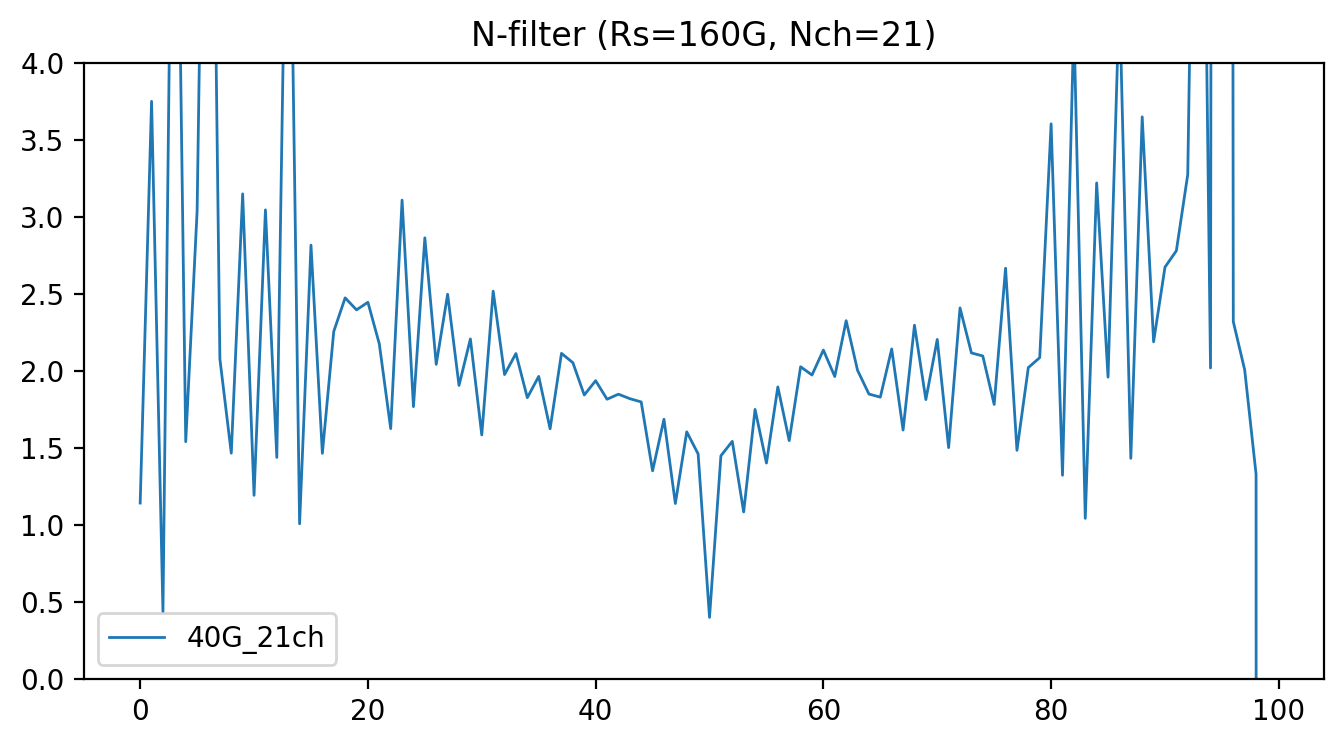

In [13]:
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 160, 21
plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})')

s,e = 350, 450
for key in ['40G_21ch']:
    plt.plot(kernels[key][0,0][s:e] / kernels[key][0,1][s:e], linewidth=1, label=key)
plt.legend()
plt.ylim(0, 4)

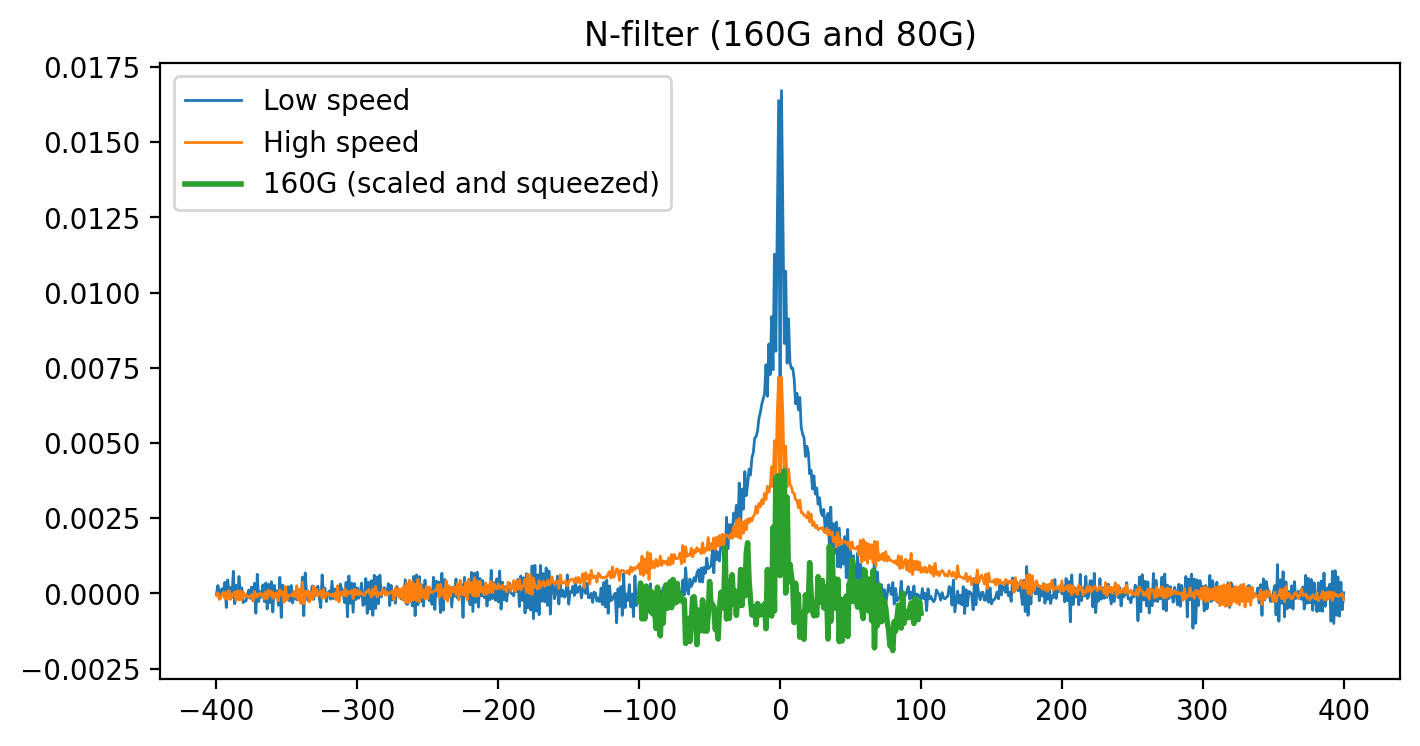

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 80, 21
plt.title(f'N-filter (160G and 80G)')

kernels = [torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch', '80G_21ch' ]]
x = np.arange(-400, 401)

plt.plot(x, kernels[0][1,1] , linewidth=1, label='Low speed')
plt.plot(x, kernels[1][1,1],  linewidth=1, label='High speed')
plt.plot(x[300:501], kernels[1][1,1][0::4] * 4 - kernels[0][1,1][300:501], linewidth=2, label='160G (scaled and squeezed)')
plt.legend(loc='upper left')

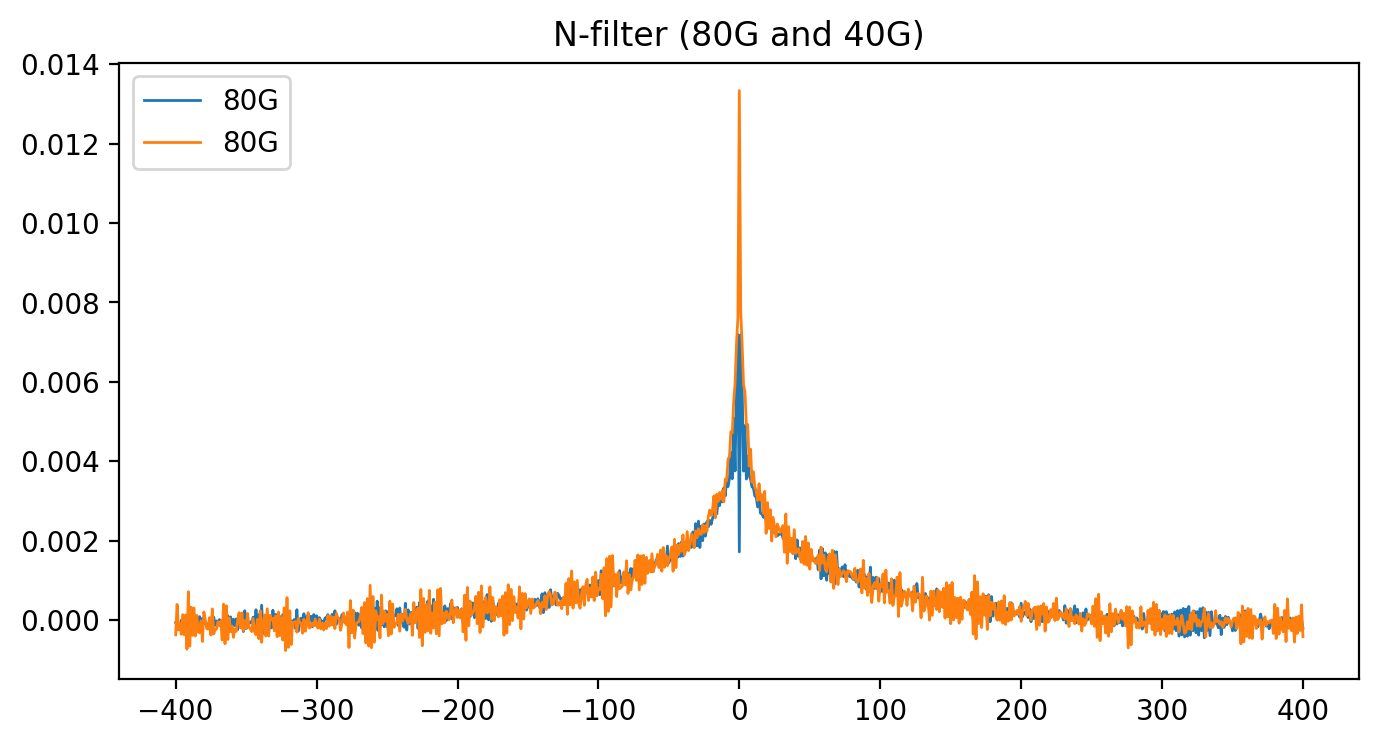

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=200)
Rs, Nch = 80, 21
plt.title(f'N-filter (80G and 40G)')

def normalize(kernel):
    kernel = kernel - kernel.mean()
    return kernel / torch.mean(kernel**2)

kernels = [torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch', '80G_21ch' ]]

x = np.arange(-400, 401)

# plt.plot(x, kernels[0][1,0] , linewidth=1, label='40G')
plt.plot(x, kernels[1][1,1],  linewidth=1, label='80G')
plt.plot(x, kernels[1][1,0]*2,  linewidth=1, label='80G')
# plt.plot(x[150:251], kernels[1][1,1][0::4] * 4, linewidth=2, label='80G (scaled and squeezed)')
plt.legend(loc='upper left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


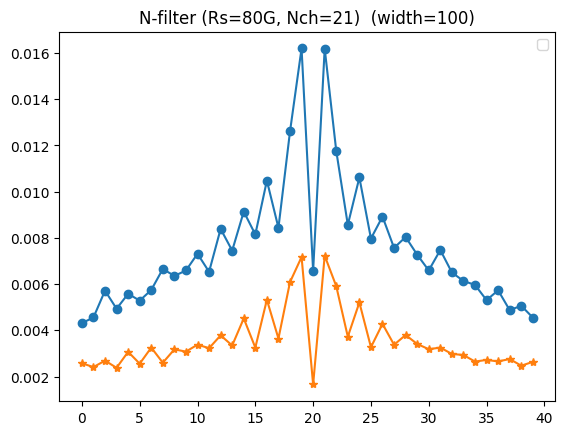

In [12]:
import torch
import matplotlib.pyplot as plt
plt.figure(dpi=100)
Rs, Nch = 80, 21

kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})  (width=100)')
s,e = 380, 420
taps = 801
inp = torch.stack([torch.abs(torch.linspace(-1,1,taps))], dim=-1)
plt.plot(kernels['40G_21ch'][0,0][s:e], '-o')
plt.plot(kernels['80G_21ch'][0,0][s:e] , '-*')
# plt.plot(kernels['160G_21ch'][0,0][s:e] , '-*')

# plt.plot(net.task_mlp(inp)[:,0].data, label='N_xx (adf)')
# plt.plot(model.task_mlp(inp)[:,0].data[350:450], label='N_xy (adf)', linewidth=2)
# plt.plot(kernels['40G_21ch'][1,1][s:e], '-o')
# plt.plot(kernels['80G_21ch'][1,1][s:e] , '-*')
# plt.plot(kernels['160G_21ch'][1,1][s:e] , '-*')
# plt.plot(net.task_mlp(inp)[:,2].data, label='N_yx (adf)')
# plt.plot(net.task_mlp(inp)[:,3].data, label='N_yy (adf)')
plt.legend()

## show NewDBP Filter

In [12]:
import torch
import matplotlib.pyplot as plt
kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}

# dic = torch.load('_models/NewDBP/80G_21ch/30.pth')
# model = LDBP(dic['dbp_info'])
# model.load_state_dict(dic['dbp_param'])
# model = model.to('cuda:0')  

In [9]:
net = net.to('cpu')

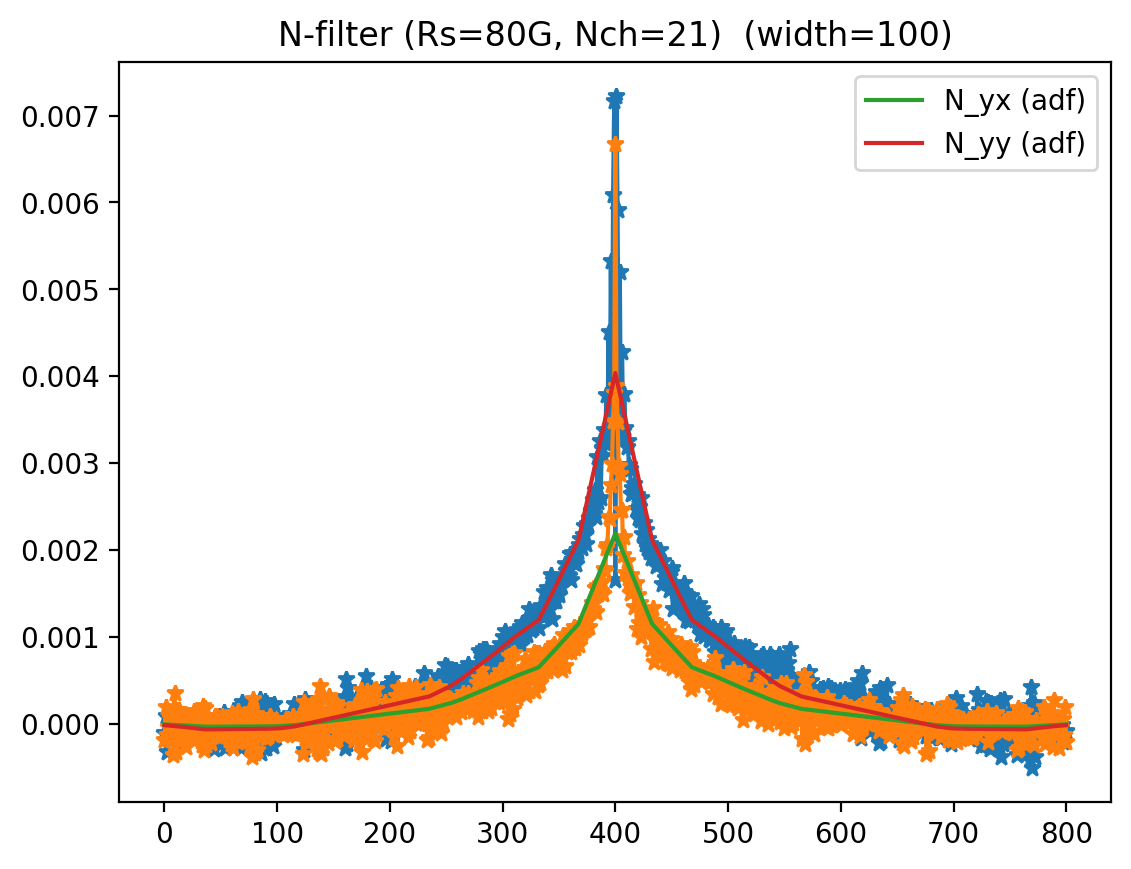

In [20]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
Rs, Nch = 80, 21

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})  (width=100)')
s,e = 380, 420
taps = 801
inp = torch.stack([torch.abs(torch.linspace(-1,1,taps))], dim=-1)
# plt.plot(net.task_mlp(inp)[:,0].data, label='N_xx (adf)')
# plt.plot(model.task_mlp(inp)[:,0].data[350:450], label='N_xy (adf)', linewidth=2)
# plt.plot(kernels['40G_21ch'][0,0][s:e], '-o')
# plt.plot(kernels['40G_21ch'][1,1][s:e], '-o')
plt.plot(kernels['80G_21ch'][0,0] , '-*')
plt.plot(kernels['80G_21ch'][1,0] , '-*')
# plt.plot(kernels['160G_21ch'][0,0][s:e] , '-*')
# plt.plot(kernels['160G_21ch'][1,1][s:e] , '-*')
plt.plot(net.task_mlp(inp)[:,2].data, label='N_yx (adf)')
plt.plot(net.task_mlp(inp)[:,3].data, label='N_yy (adf)')
plt.legend()

In [21]:
net

LDBP(
  (task_mlp): MLP_func(
    (fc1): Linear(in_features=1, out_features=80, bias=True)
    (fc2): Linear(in_features=80, out_features=40, bias=True)
    (fc3): Linear(in_features=40, out_features=2, bias=True)
    (fc4): Linear(in_features=2, out_features=4, bias=False)
  )
)

## show MetaDBP filter

In [ ]:

import matplotlib.pyplot as plt
plt.figure(dpi=200)
Rs, Nch = 80, 21

plt.title(f'N-filter (Rs={Rs}G, Nch={Nch})')

net.to('cpu')
plt.plot(net.task_mlp(torch.tensor([2, 0, 160e9, 21])).reshape(2,2,201)[1,1].cpu().data, label='N_xx (adf)')
plt.plot(net.task_mlp(torch.tensor([2, 0, 120e9, 21])).reshape(2,2,201)[1,1].cpu().data, label='N_xx (adf)')

plt.legend()

# Find kernel relationship

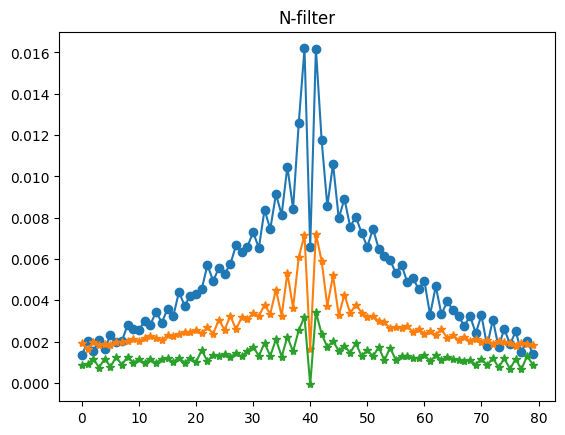

In [10]:
import torch
import matplotlib.pyplot as plt
plt.figure(dpi=100)
Rs, Nch = 80, 21

kernels = {key: torch.load(f'_outputs/kernel_801/{key}.pt') for key in ['40G_21ch','80G_11ch', '80G_21ch', '160G_21ch']}
plt.title(f'N-filter')
s,e = 360, 440

plt.plot(kernels['40G_21ch'][0,0][s:e] , '-o')
plt.plot(kernels['80G_21ch'][0,0][s:e] , '-*')
plt.plot(kernels['160G_21ch'][0,0][s:e] , '-*')

# plt.plot(kernels['40G_21ch'][0,0][s:e] / kernels['160G_21ch'][0,0][s:e], '-o')
# plt.ylim(0, 5)

Text(0.5, 1.0, '40G - 80G  N_xx')

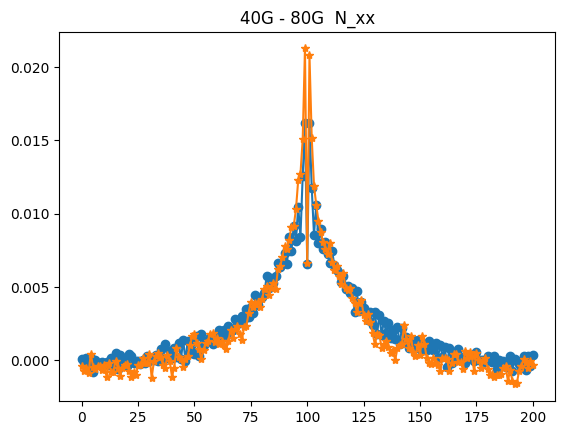

In [13]:
plt.plot(kernels['40G_21ch'][0,0][300:501] , '-o')
plt.plot(4*kernels['80G_21ch'][0,0][0::4] , '-*')

plt.title('40G - 80G  N_xx')

Text(0.5, 1.0, '40G - 80G  N_xy')

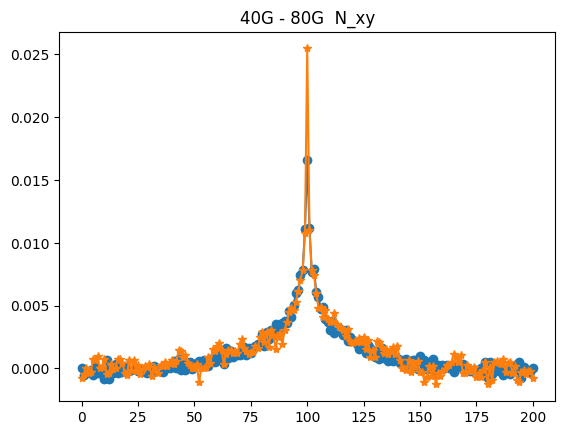

In [3]:
plt.plot(kernels['40G_21ch'][0,1][300:501] , '-o')
plt.plot(4*kernels['80G_21ch'][0,1][0::4] , '-*')
plt.title('40G - 80G  N_xy')

Text(0.5, 1.0, '80G - 160G  N_xx')

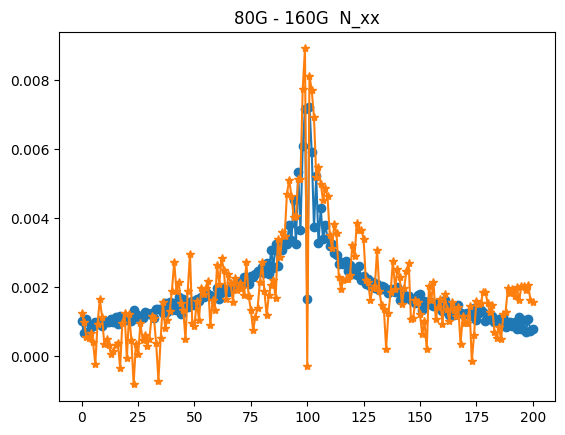

In [64]:
plt.plot(kernels['80G_21ch'][0,0][300:501] , '-o')
plt.plot(4*kernels['160G_21ch'][0,0][0::4] , '-*')
plt.title('80G - 160G  N_xx')

Text(0.5, 1.0, '80G - 160G  N_xy')

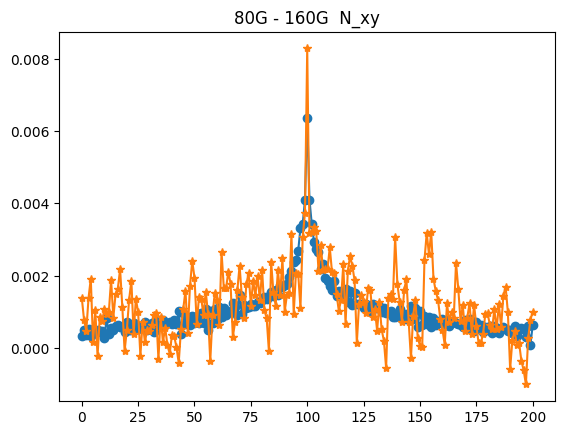

In [65]:
plt.plot(kernels['80G_21ch'][0,1][300:501] , '-o')
plt.plot(4*kernels['160G_21ch'][0,1][0::4] , '-*')
plt.title('80G - 160G  N_xy')

(0.0, 5.0)

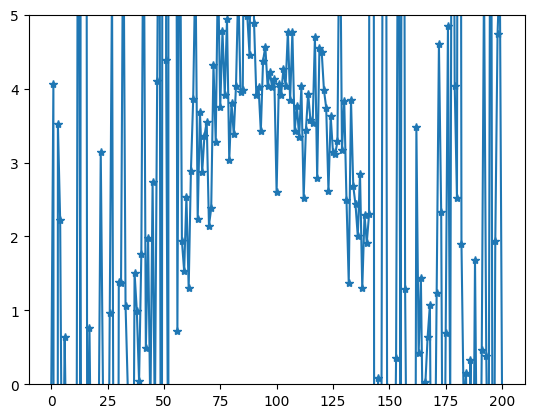

In [56]:
k1 = kernels['40G_21ch'][0,1][300:501]
k2 = kernels['80G_21ch'][0,1][0::4]

# plt.plot(k1, '-o')
# plt.plot(k2 , '-*')


plt.plot(k1 / k2 , '-*')
plt.ylim(0,5)